In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import prep
import acquire

## Sentiment analysis of books of different religious texts

An overview using natural language processing and vader sentiment analysis to look at what percent of verses are very positive, positive, neutral, negative, and very negative.

### Bible

In [2]:
df = acquire.bookofmormon_wrangle()

In [3]:
df.head(2)

,id,book_no,book,test,ch,ver,text
31102,3,67,1 Nephi,His Reign and Ministry,1,1,"I, Nephi, having been born of goodly parents, ..."
31103,3,67,1 Nephi,His Reign and Ministry,1,2,"Yea, I make a record in the language of my fat..."


In [4]:
#removing stopwords, lower casing, and tokenizing each verse.
df.text = df.text.apply(prep.basic_clean)
df.text = df.text.apply(prep.remove_stopwords)

In [5]:
# creating column for each verse stemmed.
df['stemmed'] = df.text.apply(prep.stem)

In [6]:
df.head(2)

,id,book_no,book,test,ch,ver,text,stemmed
31102,3,67,1 Nephi,His Reign and Ministry,1,1,nephi born goodly parents therefore taught som...,nephi born goodli parent therefor taught somew...
31103,3,67,1 Nephi,His Reign and Ministry,1,2,yea make record language father consists learn...,yea make record languag father consist learn j...


In [7]:
# Sentiment intensity algorithm initialized
sia = SentimentIntensityAnalyzer()

In [8]:
# Example of how SIA scores a corpus.
blob = "For God so loved the world that he gave his only son to die for us"
sia.polarity_scores(blob)

{'neg': 0.163, 'neu': 0.542, 'pos': 0.296, 'compound': 0.4924}

In [9]:
df.head(2)

,id,book_no,book,test,ch,ver,text,stemmed
31102,3,67,1 Nephi,His Reign and Ministry,1,1,nephi born goodly parents therefore taught som...,nephi born goodli parent therefor taught somew...
31103,3,67,1 Nephi,His Reign and Ministry,1,2,yea make record language father consists learn...,yea make record languag father consist learn j...


In [10]:
df['vader_sentiment'] = df.text.apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [11]:
df_book_avg = df.groupby('book')['book','book_no','vader_sentiment'].mean().sort_values(by='book_no')
print("Average sentiment by book")
df_book_avg

Average sentiment by book


,book_no,vader_sentiment
book,,
1 Nephi,67,0.125650
2 Nephi,68,0.082681
Jacob,69,0.150916
Enos,70,0.142215
Jarom,71,0.025633
Omni,72,-0.002953
Words of Mormon,73,0.184606
Mosiah,74,0.052830
Alma,75,0.068462


In [12]:
#joinging each book into a complete corpus
df_books = pd.DataFrame(df.groupby('book')['text'].apply(list))
df_books.text = df_books.text.apply(prep.text_join)

In [13]:
df_books.head()

,text
book,
1 Nephi,nephi born goodly parents therefore taught som...
2 Nephi,came pass nephi made end teaching brethren fat...
3 Nephi,came pass ninety first year passed away six hu...
4 Nephi,came pass thirty fourth year passed away also ...
Alma,came pass first year reign judges people nephi...


In [14]:
#grouping verses by chapter and applying vader sentiment score to each chapter
df_chap = pd.DataFrame(df.groupby(['book','ch'])['text'].apply(list))
df_chap.text = df_chap.text.apply(prep.text_join)
df_chap['vader_sentiment'] = df_chap.text.apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [15]:
#removing some additional stopwords and grouping by word frequency
df_books.text = df_books.text.apply(prep.remove_stopwords, args=(['said','thee','ye','thou','thy',"'",'shall','unto'],))
raw_count = pd.Series(" ".join(df_books.text).split()).value_counts()

10 most common words


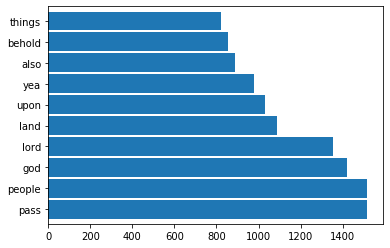

In [16]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
print('10 most common words')

In [17]:
#assigning sentiment groups based on vader score. 
#Very positive, positive, neutral, negative, and very negative
df['vader'] = round(df.vader_sentiment,1)
df['sentiment_group'] = np.where(df.vader >= .7,'very positive',np.where(df.vader>=.1,'positive',np.where(df.vader == 0,'neutral',np.where(df.vader >= -.6,'negative','very negative'))))

In [18]:
#total verse count for each book
verse_count = df.groupby('book').count()
verse_count.reset_index(inplace=True)
verse_count = verse_count[['book','sentiment_group']]
verse_count.head(2)

,book,sentiment_group
0,1 Nephi,618
1,2 Nephi,779


In [19]:
#total verses by book and sentiment group
df_likert = df.groupby(['book','sentiment_group'])['id'].count().reset_index()

In [20]:
df_likert.head(8)

,book,sentiment_group,id
0,1 Nephi,negative,114
1,1 Nephi,neutral,163
2,1 Nephi,positive,202
3,1 Nephi,very negative,42
4,1 Nephi,very positive,97
5,2 Nephi,negative,165
6,2 Nephi,neutral,146
7,2 Nephi,positive,228


In [21]:
df_likert_total = pd.merge(df_likert,verse_count,left_on='book',right_on='book')

In [22]:
df_likert_total.head(2)

,book,sentiment_group_x,id,sentiment_group_y
0,1 Nephi,negative,114,618
1,1 Nephi,neutral,163,618


In [23]:
#calculating percent of each sentiment group by book
df_likert_total['percent'] = round(df_likert_total.id/df_likert_total.sentiment_group_y,2)

In [24]:
df_likert_total.head(5)

,book,sentiment_group_x,id,sentiment_group_y,percent
0,1 Nephi,negative,114,618,0.18
1,1 Nephi,neutral,163,618,0.26
2,1 Nephi,positive,202,618,0.33
3,1 Nephi,very negative,42,618,0.07
4,1 Nephi,very positive,97,618,0.16


In [25]:
#grabbing book # for sorting in Tableau
df_books = df.groupby('book')[['book','book_no']].mean()
df_books.sort_values(by='book_no')

,book_no
book,
1 Nephi,67
2 Nephi,68
Jacob,69
Enos,70
Jarom,71
Omni,72
Words of Mormon,73
Mosiah,74
Alma,75


In [26]:
#final table for tableau viz
#book name, sentiment group, total verses, percent of verse, and book no
df_likert_final = pd.merge(df_likert_total,df_books,left_on='book',right_on='book')
df_likert_final.columns = ['book','sentiment','sentiment_verses','total_verses','percent','book_no']

In [27]:
df_likert_final.head(15)

,book,sentiment,sentiment_verses,total_verses,percent,book_no
0,1 Nephi,negative,114,618,0.18,67
1,1 Nephi,neutral,163,618,0.26,67
2,1 Nephi,positive,202,618,0.33,67
3,1 Nephi,very negative,42,618,0.07,67
4,1 Nephi,very positive,97,618,0.16,67
5,2 Nephi,negative,165,779,0.21,68
6,2 Nephi,neutral,146,779,0.19,68
7,2 Nephi,positive,228,779,0.29,68
8,2 Nephi,very negative,99,779,0.13,68
9,2 Nephi,very positive,141,779,0.18,68


In [28]:
df_likert_final.to_csv("bookofmormon_by_book_likert.csv",index=False)

In [29]:
pd.read_csv('bookofmormon_by_book_likert.csv').sort_values(by='book_no')

,book,sentiment,sentiment_verses,total_verses,percent,book_no
0,1 Nephi,negative,114,618,0.18,67
1,1 Nephi,neutral,163,618,0.26,67
2,1 Nephi,positive,202,618,0.33,67
3,1 Nephi,very negative,42,618,0.07,67
4,1 Nephi,very positive,97,618,0.16,67
5,2 Nephi,negative,165,779,0.21,68
6,2 Nephi,neutral,146,779,0.19,68
7,2 Nephi,positive,228,779,0.29,68
8,2 Nephi,very negative,99,779,0.13,68
9,2 Nephi,very positive,141,779,0.18,68


<img src="files/old_testament.png">

<img src="files/new_testament.png">

### Book of Mormon

In [2]:
df = acquire.bookofmormon_wrangle()
#df = pd.read_csv('lds-scriptures.csv')

In [3]:
df.head(2)

,id,book_no,book,test,ch,ver,text
31102,3,67,1 Nephi,His Reign and Ministry,1,1,"I, Nephi, having been born of goodly parents, ..."
31103,3,67,1 Nephi,His Reign and Ministry,1,2,"Yea, I make a record in the language of my fat..."
